#LAB 3 
- In this lab assignment, we are required to work on Optimization of models in machine learning.
- The three methods we are supposed to implement are quantization, pruning and clustering.
- In the second part of the assignment, we have to implement the Object detection on videos and 2000 cats and 2000 bobcats Raw images. First, we will use labelImg or Roboflow to create the .xml files in Pascal VOC format to train the model.
- Another aspect we have to look in to is the implmentation of the ssdmobilenet v1 on real videos of cats and Bobcats.

Importing Libraries


In [34]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import sys
import zipfile
import pathlib
import matplotlib.pyplot as plt
%matplotlib inline
import tempfile
mobile = tf.keras.applications.mobilenet.MobileNet()


Mounting google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#train and validation dataset

PATH= "/content/drive/MyDrive/ENSF511_LAB3/MobileNet-samples"
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
BATCH_SIZE = 64
IMG_SIZE = (224, 224)
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)
class_names = train_dataset.class_names

Found 3000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


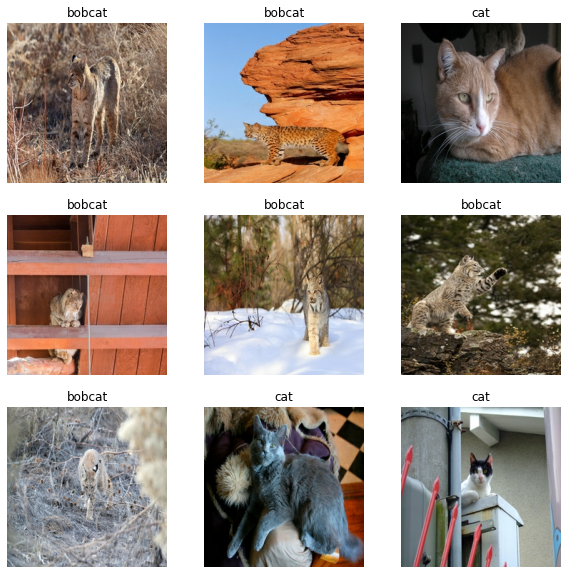

In [ ]:
#sample images of the dataset
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [3]:
print(class_names)  
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

['bobcat', 'cat']
Number of validation batches: 13
Number of test batches: 3


In [4]:
#autotuning of dataset

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)


IMG_SHAPE = IMG_SIZE + (3,)

In [5]:
#defining the base model
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(64, 7, 7, 1280)


In [6]:
#keeping the base model traning as false.
base_model.trainable = False

# Let's take a look at the base model architecture
base_model.summary()


Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [7]:
#adding average pooling and dense layer
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)



(64, 1280)
(64, 1)


In [8]:
#defining the model
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()   
print(len(model.trainable_variables)           )

initial_epochs = 30

                  

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                             

In [9]:
#model training
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

                  

Epoch 1/30
47/47 [==============================] - 22s 336ms/step - loss: 0.7218 - accuracy: 0.5343 - val_loss: 0.4776 - val_accuracy: 0.7809
Epoch 2/30
47/47 [==============================] - 15s 285ms/step - loss: 0.5186 - accuracy: 0.7340 - val_loss: 0.3569 - val_accuracy: 0.8923
Epoch 3/30
47/47 [==============================] - 15s 285ms/step - loss: 0.4058 - accuracy: 0.8213 - val_loss: 0.2859 - val_accuracy: 0.9530
Epoch 4/30
47/47 [==============================] - 16s 289ms/step - loss: 0.3332 - accuracy: 0.8750 - val_loss: 0.2355 - val_accuracy: 0.9691
Epoch 5/30
47/47 [==============================] - 14s 278ms/step - loss: 0.2815 - accuracy: 0.9027 - val_loss: 0.2114 - val_accuracy: 0.9740
Epoch 6/30
47/47 [==============================] - 15s 282ms/step - loss: 0.2352 - accuracy: 0.9297 - val_loss: 0.1821 - val_accuracy: 0.9740
Epoch 7/30
47/47 [==============================] - 15s 281ms/step - loss: 0.2065 - accuracy: 0.9407 - val_loss: 0.1680 - val_accuracy: 0.9715

Plots showing accuracy and loss for the above model

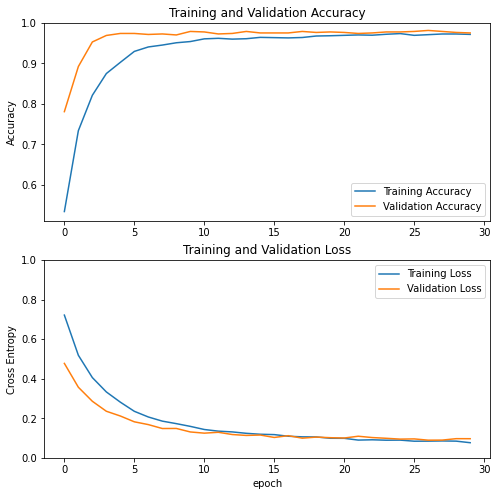

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()                    

- We can observe that after almost 12 epochs, the accuracy becomes almost stable with no further increase. As a consequence, we have to now decrease the error learning rate as to see, if the accuracy can further be increased with epoch
- Moreover, we can try fine tuning the model by adding some trainable layers in order to increase the accuracy with increase in epochs

In [11]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [12]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                             

In [14]:
len(model.trainable_variables)

2

In [15]:
fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 30/50
47/47 [==============================] - 23s 305ms/step - loss: 0.0791 - accuracy: 0.9747 - val_loss: 0.0893 - val_accuracy: 0.9777
Epoch 31/50
47/47 [==============================] - 15s 281ms/step - loss: 0.0760 - accuracy: 0.9737 - val_loss: 0.0898 - val_accuracy: 0.9777
Epoch 32/50
47/47 [==============================] - 15s 292ms/step - loss: 0.0775 - accuracy: 0.9750 - val_loss: 0.0913 - val_accuracy: 0.9777
Epoch 33/50
47/47 [==============================] - 15s 283ms/step - loss: 0.0808 - accuracy: 0.9763 - val_loss: 0.0874 - val_accuracy: 0.9777
Epoch 34/50
47/47 [==============================] - 15s 281ms/step - loss: 0.0797 - accuracy: 0.9737 - val_loss: 0.0888 - val_accuracy: 0.9790
Epoch 35/50
47/47 [==============================] - 15s 284ms/step - loss: 0.0755 - accuracy: 0.9750 - val_loss: 0.0903 - val_accuracy: 0.9765
Epoch 36/50
47/47 [==============================] - 15s 286ms/step - loss: 0.0796 - accuracy: 0.9703 - val_loss: 0.0862 - val_accuracy:

In [16]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

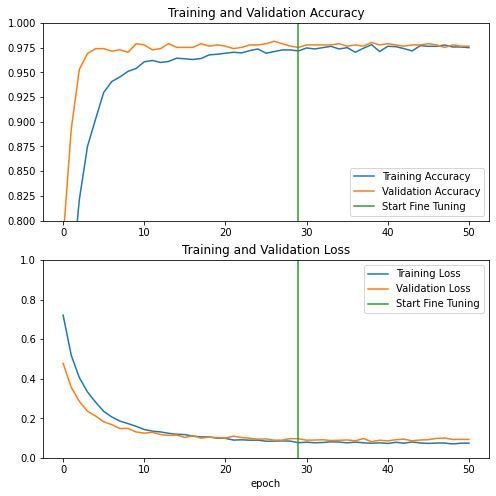

In [17]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [19]:
loss_base, accuracy_base = model.evaluate(test_dataset)
print('Test accuracy :', accuracy_base)

3/3 [==============================] - 3s 211ms/step - loss: 0.0782 - accuracy: 0.9792
Test accuracy : 0.9791666865348816


- We can see that there has been a slight increase in the accuracy when the model is fine tuned at 100 layers and learning rate is slightly decreased.

## Testing on a bacth of test dataset

Predictions:
 [1 1 1 1 1 1 0 1 1 0 0 0 1 1 0 1 1 1 1 0 1 1 0 0 1 1 0 1 0 0 1 0]
Labels:
 [1 1 1 1 1 1 0 1 1 0 0 0 1 1 0 1 1 1 1 0 1 1 0 0 1 1 0 1 0 0 0 0]


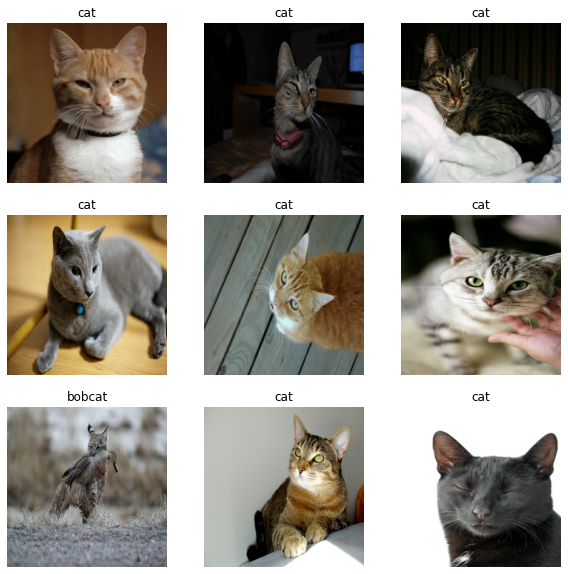

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

- saving the model for future use

In [20]:
model.save('/content/drive/MyDrive/ENSF511_LAB3/Models/Base_model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ENSF511_LAB3/Models/Base_model/assets


#1.1 Quantization

- Quantization is the first method to decrease the model size while keeping the accuracy same

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/ENSF_511_LAB3/Models/Base_model')

In [ ]:
import tensorflow as tf

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model('/content/drive/MyDrive/ENSF_511_LAB3/Models/Base_model') # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('/content/drive/MyDrive/ENSF_511_LAB3/Models/Base_model_lite/model.tflite', 'wb') as f:
  f.write(tflite_model)

In [20]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpoqnb3zb9/assets


In [21]:
import sys
print(sys.getsizeof(tflite_model))

8872337


## 1.1.1 Quantization to float 16

In [22]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_fp16_model = converter.convert()
print(sys.getsizeof(tflite_fp16_model))

INFO:tensorflow:Assets written to: /tmp/tmp3o478heb/assets


INFO:tensorflow:Assets written to: /tmp/tmp3o478heb/assets


4476401


#### Note : We can see that the model size has been quantized to almost half.

In [23]:
import pathlib
tflite_models_dir = pathlib.Path("/content/sample_data/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

tflite_model_file = tflite_models_dir/"base_model.tflite"
tflite_model_file.write_bytes(tflite_model)

8872304

In [24]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_fp16_model = converter.convert()
tflite_model_fp16_file = tflite_models_dir/"base_fp16_model.tflite"
tflite_model_fp16_file.write_bytes(tflite_fp16_model)

INFO:tensorflow:Assets written to: /tmp/tmpjpe0hw69/assets


INFO:tensorflow:Assets written to: /tmp/tmpjpe0hw69/assets


4476368

In [25]:
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()

interpreter_fp16 = tf.lite.Interpreter(model_path=str(tflite_model_fp16_file))
interpreter_fp16.allocate_tensors()

In [26]:
test_image = np.expand_dims(image_batch[4], axis=0).astype(np.float32)

input_index = interpreter_fp16.get_input_details()[0]["index"]
output_index = interpreter_fp16.get_output_details()[0]["index"]

interpreter_fp16.set_tensor(input_index, test_image)
interpreter_fp16.invoke()
predictions = interpreter_fp16.get_tensor(output_index)
predictions

array([[4.1081996]], dtype=float32)

In [29]:
# A helper function to evaluate the TF Lite model using "test" dataset.
def evaluate_model(interpreter):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on every image in the "test" dataset.
  prediction = []
  for test_image in image_batch:
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction.append(digit)

  # Compare prediction results with ground truth labels to calculate accuracy.
  accurate_count = 0
  for index in range(len(prediction)):
    if prediction[index] == label_batch[index]:
      accurate_count += 1
  accuracy = accurate_count * 1.0 / len(prediction)

  return accuracy


In [30]:
print(evaluate_model(interpreter))

0.5


#1.2 Pruning 

- The second method to decrease the model size is the Pruning of parameters 

In [21]:
!pip install -q tensorflow-model-optimization
import tensorflow_model_optimization as tfmot
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

     |████████████████████████████████| 237 kB 5.3 MB/s 


- For the sake of simplicity we are applying the pruning on the dense layers of the model

In [22]:
def apply_pruning_to_dense(layer):
  if isinstance(layer, tf.keras.layers.Dense):
    return tfmot.sparsity.keras.prune_low_magnitude(layer)
  return layer

# Use `tf.keras.models.clone_model` to apply `apply_pruning_to_dense` 
# to the layers of the model.
model_for_pruning = tf.keras.models.clone_model(
    model,
    clone_function=apply_pruning_to_dense,
)

model_for_pruning.summary()

/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:218: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  aggregation=tf.VariableAggregation.MEAN)
/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:225: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  aggregation=tf.VariableAggregation.MEAN)
/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:238: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=False)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                             

In [23]:
model_for_pruning.compile(optimizer='adam',
               loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),  metrics=['accuracy'])

logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

history_pru= model_for_pruning.fit(train_dataset,
                  batch_size=64, epochs=15, validation_data=validation_dataset,
                  callbacks=callbacks)

Epoch 1/15
47/47 [==============================] - 27s 312ms/step - loss: 0.0753 - accuracy: 0.9730 - val_loss: 0.0940 - val_accuracy: 0.9777
Epoch 2/15
47/47 [==============================] - 15s 293ms/step - loss: 0.0604 - accuracy: 0.9797 - val_loss: 0.1036 - val_accuracy: 0.9777
Epoch 3/15
47/47 [==============================] - 16s 295ms/step - loss: 0.0554 - accuracy: 0.9830 - val_loss: 0.0932 - val_accuracy: 0.9752
Epoch 4/15
47/47 [==============================] - 15s 292ms/step - loss: 0.0556 - accuracy: 0.9777 - val_loss: 0.0858 - val_accuracy: 0.9790
Epoch 5/15
47/47 [==============================] - 16s 307ms/step - loss: 0.0542 - accuracy: 0.9820 - val_loss: 0.0901 - val_accuracy: 0.9777
Epoch 6/15
47/47 [==============================] - 15s 293ms/step - loss: 0.0534 - accuracy: 0.9807 - val_loss: 0.0780 - val_accuracy: 0.9802
Epoch 7/15
47/47 [==============================] - 16s 311ms/step - loss: 0.0526 - accuracy: 0.9803 - val_loss: 0.0782 - val_accuracy: 0.9777

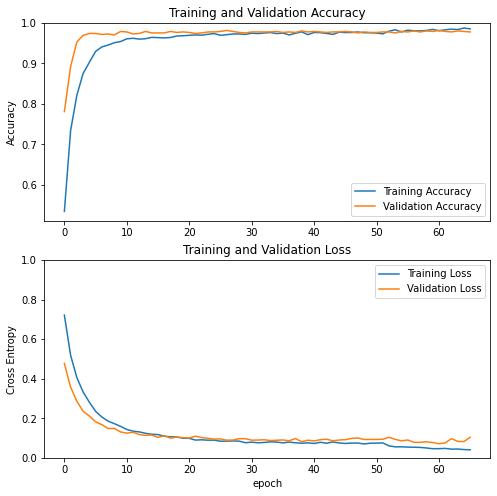

In [26]:
acc += history_pru.history['accuracy']
val_acc += history_pru.history['val_accuracy']

loss += history_pru.history['loss']
val_loss += history_pru.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()  

In [28]:
loss_pru, accuracy_pru = model_for_pruning.evaluate(test_dataset)
print('Test accuracy :', accuracy_pru)

3/3 [==============================] - 3s 209ms/step - loss: 0.0782 - accuracy: 0.9896
Test accuracy : 0.9895833134651184


- As we can observe, pruning does not decrease the accuracy if we do the pruning at the dense layers.

In [35]:
print('Size of model :',sys.getsizeof(model_for_pruning))

Size of model 64


## 1.3 Clustering

- The next method of optimization is clustering in which smae weights are clustered together in order to decrease the model size while retaining the accuracy

In [29]:
cluster_weights = tfmot.clustering.keras.cluster_weights
CentroidInitialization = tfmot.clustering.keras.CentroidInitialization

clustering_params = {
  'number_of_clusters': 16,
  'cluster_centroids_init': CentroidInitialization.LINEAR
}

# Cluster a whole model
clustered_model = cluster_weights(model, **clustering_params)

# Use smaller learning rate for fine-tuning clustered model
opt = tf.keras.optimizers.Adam(learning_rate=1e-5)

clustered_model.compile(
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
  optimizer=opt,
  metrics=['accuracy'])

clustered_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 cluster_tf.math.truediv (Cl  (None, 224, 224, 3)      0         
 usterWeights)                                                   
                                                                 
 cluster_tf.math.subtract (C  (None, 224, 224, 3)      0         
 lusterWeights)                                                  
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                             

In [30]:
# training model
history_clu= clustered_model.fit(
  train_dataset,
  batch_size=64,
  epochs=15,
  validation_data=validation_dataset)

Epoch 1/15
47/47 [==============================] - 23s 370ms/step - loss: 0.0830 - accuracy: 0.9770 - val_loss: 0.1740 - val_accuracy: 0.9554
Epoch 2/15
47/47 [==============================] - 16s 298ms/step - loss: 0.0722 - accuracy: 0.9800 - val_loss: 0.1650 - val_accuracy: 0.9653
Epoch 3/15
47/47 [==============================] - 16s 297ms/step - loss: 0.0678 - accuracy: 0.9823 - val_loss: 0.1815 - val_accuracy: 0.9480
Epoch 4/15
47/47 [==============================] - 16s 298ms/step - loss: 0.0616 - accuracy: 0.9823 - val_loss: 0.1577 - val_accuracy: 0.9592
Epoch 5/15
47/47 [==============================] - 16s 302ms/step - loss: 0.0560 - accuracy: 0.9833 - val_loss: 0.1518 - val_accuracy: 0.9604
Epoch 6/15
47/47 [==============================] - 16s 315ms/step - loss: 0.0526 - accuracy: 0.9860 - val_loss: 0.1568 - val_accuracy: 0.9604
Epoch 7/15
47/47 [==============================] - 16s 303ms/step - loss: 0.0553 - accuracy: 0.9833 - val_loss: 0.1481 - val_accuracy: 0.9554

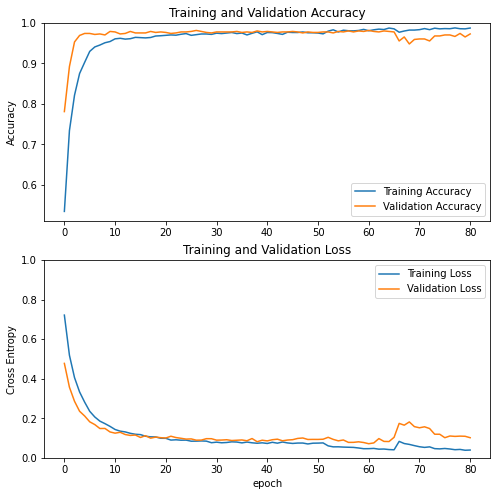

In [32]:
acc += history_clu.history['accuracy']
val_acc += history_clu.history['val_accuracy']

loss += history_clu.history['loss']
val_loss += history_clu.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()  

In [39]:
loss_clu, accuracy_clu = clustered_model.evaluate(test_dataset)
print('Test accuracy :', accuracy_clu)

3/3 [==============================] - 2s 196ms/step - loss: 0.1071 - accuracy: 0.9688
Test accuracy : 0.96875


- As we can see that the accuracy of the model has been slightly decreased as compared to the pruning and normal classification. 

In [36]:
print('Size of model :',sys.getsizeof(clustered_model))

Size of model : 64


# 2. Performance evaluation by reducing the size of image

In [41]:

PATH= "/content/drive/MyDrive/ENSF511_LAB3/MobileNet-samples"
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
BATCH_SIZE = 64
IMG_SIZE = (112, 112) # image sie reduced 
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)
class_names = train_dataset.class_names

Found 3000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [42]:
print(class_names)  
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

['bobcat', 'cat']
Number of validation batches: 13
Number of test batches: 3


In [43]:

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)


IMG_SHAPE = IMG_SIZE + (3,)

In [44]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(64, 4, 4, 1280)


In [45]:
base_model.trainable = False

# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 112, 112, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 56, 56, 32)   864         ['input_5[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 56, 56, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 56, 56, 32)   0           ['bn_Conv1[0][

In [64]:
#adding layers
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(64, 1280)
(64, 1)


In [49]:
inputs = tf.keras.Input(shape=(112, 112, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()   
print(len(model.trainable_variables)           )

initial_epochs = 30

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 112, 112, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, None, None, 3)     0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 112, 112, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 112, 112, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                           

In [50]:
#model training
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/30
47/47 [==============================] - 18s 252ms/step - loss: 1.1429 - accuracy: 0.4763 - val_loss: 0.8766 - val_accuracy: 0.5804
Epoch 2/30
47/47 [==============================] - 11s 213ms/step - loss: 0.8124 - accuracy: 0.6147 - val_loss: 0.6583 - val_accuracy: 0.6881
Epoch 3/30
47/47 [==============================] - 12s 233ms/step - loss: 0.6072 - accuracy: 0.7170 - val_loss: 0.5217 - val_accuracy: 0.7735
Epoch 4/30
47/47 [==============================] - 12s 223ms/step - loss: 0.4910 - accuracy: 0.7710 - val_loss: 0.3981 - val_accuracy: 0.8552
Epoch 5/30
47/47 [==============================] - 12s 220ms/step - loss: 0.4122 - accuracy: 0.8157 - val_loss: 0.3453 - val_accuracy: 0.8874
Epoch 6/30
47/47 [==============================] - 11s 216ms/step - loss: 0.3521 - accuracy: 0.8473 - val_loss: 0.3071 - val_accuracy: 0.9022
Epoch 7/30
47/47 [==============================] - 17s 324ms/step - loss: 0.3190 - accuracy: 0.8703 - val_loss: 0.2720 - val_accuracy: 0.9146

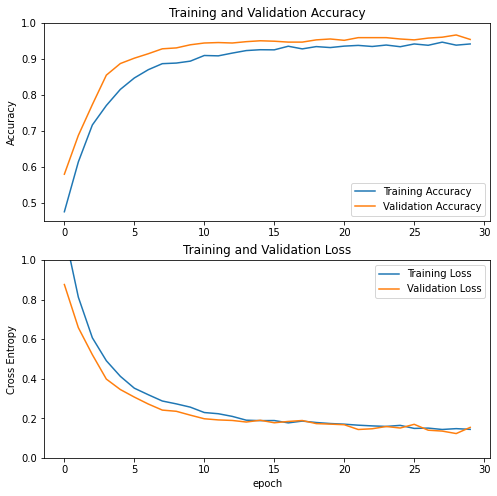

In [51]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()                    


In [52]:

loss_112, accuracy_112 = model.evaluate(test_dataset)
print('Test accuracy :', accuracy_112)


3/3 [==============================] - 2s 199ms/step - loss: 0.1645 - accuracy: 0.9583
Test accuracy : 0.9583333134651184


- As we can see that, the accuracy has been further decraesed to around 95.8% with the decrease in the image size.

In [55]:
float_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = float_converter.convert()

tflite_models_dir = pathlib.Path("/content/sample_data/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

tflite_model_file = tflite_models_dir/"model.tflite"
tflite_model_file.write_bytes(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmppur2bmmj/assets


8873224

- the model size is the same as earlier.